# Missing Values

In [9]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
from fancyimpute import KNN, SimpleFill
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn import datasets
from sklearn.metrics import confusion_matrix
import seaborn as sns
plt.style.use('ggplot')

## Generating Data


Text(0.5, 1.0, 'Training data')

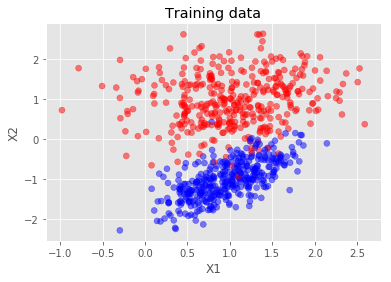

In [10]:
n=1000
np.random.seed(1)

X,Y = datasets.make_classification(n_samples = n,
                                   n_features=2,
                                   n_redundant=0,
                                   n_informative=2,
                                   n_clusters_per_class=1,
                                   class_sep=1,
                                   random_state=3)

## 0.25 of All data is saved for testing
X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.25, random_state= 42)
X, X_test, Y, Y_test = pd.DataFrame(X), pd.DataFrame(X_test), pd.DataFrame(Y), pd.DataFrame(Y_test)
plt.scatter(x=X[0], y=X[1], c=Y[0], cmap=matplotlib.colors.ListedColormap(['red', 'blue']), alpha = 0.5)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Training data")


In [11]:
"""
arg: X is df of values
     p is prop of missing data
return: X with that prop of data missing
"""
def createNaNValues(df, prop = 0.2):
    df = df.copy()
    numObs, numPred = df.shape
    for predI in range(numPred):
        missingArray = np.random.binomial(size = numObs, n = 1, p = 1-prop)
        for obsI in range(numObs):
            if not missingArray[obsI]:
                df[predI][obsI] = np.nan
    return df

## normalize a pd df for use before KNN imputation
def npNormalize(X):
    return (X - np.nanmean(X, axis=0))/np.nanstd(X, axis=0)
# example missing data
Xmissing = createNaNValues(X, 0.2)
Ymissing = createNaNValues(Y, 0.2)

## Imputation

- Classes
    - Proportional
- For Features:
    - KNN 
    - Mean 
- For a given class, no values for a feature
    - LaPlace smoothing

In [12]:
# Find proportion of class 0 of Y
# Helper function for classImpute
def classProp(df):
    sum0 = (df[0] == 0).sum()
    sum1 = (df[0] == 1).sum()
    return sum0/(sum0+sum1)

# Impute classes for binary Y by proportion of that class
# Arg is df, Returns df without missing values
def classImpute(df):
    tempDF = df.copy()
    prop0 = classProp(tempDF)
    for i in range(len(df[0])):
        if np.isnan(tempDF[0][i]):
            if random.random() > prop0:
                tempDF[0][i]= 1
            else:
                tempDF[0][i]=0
    return tempDF

### Variance Comparison 

In [13]:
## Sample Mean impute
XmeanImpute = pd.DataFrame(SimpleFill().fit_transform(Xmissing))

XmissingNormal = npNormalize(Xmissing)

# KNN impute needs normalized data (mean=0, variance =1)
XknnImpute = pd.DataFrame(KNN(k=5, verbose=False).fit_transform(XmissingNormal))

In [14]:
xVar = X.std()**2
xMissVar = Xmissing.std()**2
xMeanVar = XmeanImpute.std()**2
xKnnVar = XknnImpute.std()**2

#vector of variance in proportion to variance of original data
variances = {"x1":[1, xMissVar[0]/xVar[0], xMeanVar[0]/xVar[0], xKnnVar[0]/xVar[0]],
            "x2": [1, xMissVar[1]/xVar[1], xMeanVar[1]/xVar[1], xKnnVar[1]/xVar[1]]}


Text(0.5, 1.0, 'X2 Variance')

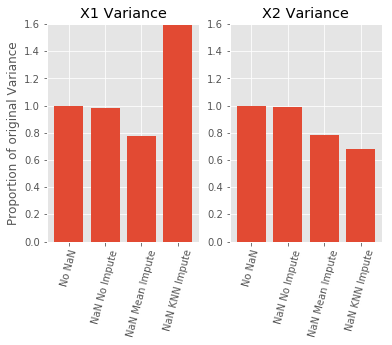

In [15]:
methodNames = ("No NaN", "NaN No Impute", "NaN Mean Impute", "NaN KNN Impute")
y_pos = np.arange(len(methodNames))

plt.subplot(121)
plt.bar(y_pos, variances['x1'], align="center")
plt.xticks(y_pos, methodNames, rotation=75)
plt.ylim(0, 1.6)
plt.ylabel("Proportion of original Variance")
plt.title("X1 Variance")

plt.subplot(122)
plt.bar(y_pos, variances['x2'], align="center")
plt.xticks(y_pos, methodNames, rotation=75)
plt.ylim(0, 1.6)
plt.title("X2 Variance")


### Normalizing Predictors

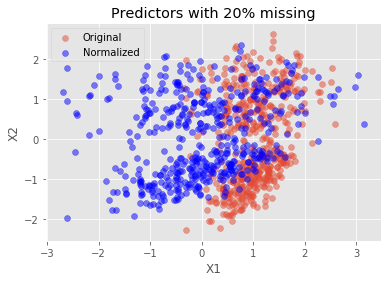

In [16]:
plt.scatter(x=Xmissing[0], y=Xmissing[1], label='Original', alpha = 0.5)
plt.scatter(x=XmissingNormal[0], y=XmissingNormal[1], c='blue',label='Normalized', alpha = 0.5)
plt.xlabel("X1")
plt.ylabel('X2')
plt.title('Predictors with 20% missing')
plt.legend()

## Naive Bayes performance

In [17]:
gnb = GaussianNB()
def getPrediction(X, Y, X_test, method=gnb):
    return method.fit(X, Y[0]).predict(X_test)

### Ytest is a pd df
def getAccuracy(Y_test, yHat):
    correct = (yHat==list(Y_test[0])).sum()
    return float(correct)/Y_test.shape[0]

def getRecall(Y_test, yHat): 
    return recall_score(Y_test, yHat)

full_yHat = getPrediction(X, Y, X_test)

full_acc = getAccuracy(Y_test, full_yHat)
full_recall= getRecall(Y_test, full_yHat)

print("Test Accuracy with no Missing: %s" % (full_acc))
print("Test Recall with no Missing: %s" % (full_recall))

Test Accuracy with no Missing: 0.96
Test Recall with no Missing: 0.9354838709677419


### X with missing data imputed

In [18]:
## Testing Accuracy function
meanImpute_pred = getPrediction(XmeanImpute, Y, X_test)
meanImpute_acc = getAccuracy(Y_test, meanImpute_pred)
print("Accuracy on X mean impute: %s \n" % (meanImpute_acc))

knnImpute_pred =getPrediction(XknnImpute, Y, X_test)
knnImpute_acc = getAccuracy(Y_test, knnImpute_pred)
print("Accuracy on X knn impute: %s" % (knnImpute_acc))

Accuracy on X mean impute: 0.96 

Accuracy on X knn impute: 0.932


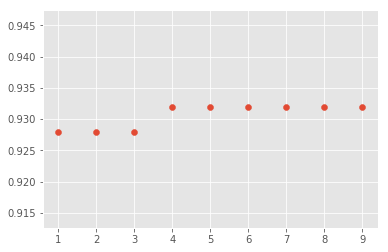

In [19]:
Xmissing30 = createNaNValues(X, 0.3)
Xmissing30Normal = npNormalize(Xmissing30)
knn_acc = list()
for i in range(1,10):
    newX = KNN(k=i, verbose=False).fit_transform(Xmissing30Normal)
    newX = pd.DataFrame(newX)
    yHat = getPrediction(newX, Y, X_test)
    newAcc = getAccuracy(Y_test, yHat)
    knn_acc.append(newAcc)

knnAccDF = pd.concat([pd.Series(range(1,10)), pd.Series(knn_acc)], axis=1)
plt.scatter(x=knnAccDF[0], y=knnAccDF[1])
    

   #### Getting a range of imputed data for X

In [28]:
### Make a list of list of X df's with different proportions
## Arg X : original predictors
## Arg props: list of proportions to be missing
## return: list of df's with props of missing data from X
def makeMissingList(X, props, ):
    X_missing_list = list()
    for i in props:
        newMissX = createNaNValues(X, i)
        newMissX = npNormalize(newMissX)
        X_missing_list.append(newMissX)
    
    return X_missing_list

### Return: df of 3 colums: proportion of missing data, accuracy of model, recall score of model
##  Args X, Y : orginal X, Y training
##  Args props : list of the proportions of missing data
##  Args impute: STRING how to impute (just mean or knn)
##  Args method: FUNCTION of how to get predictions
def getMissingAccuracies(X, Y, props, impute = 'mean', method=gnb):
    imputeFunction = SimpleFill().fit_transform if impute == 'mean' else KNN(k=10, verbose=False).fit_transform
    X_missing_list = makeMissingList(X, props)
    
    missing_acc = list()
    missing_rec = list()
    for x in X_missing_list:
        x_imputed = pd.DataFrame(imputeFunction(x))
        pred = getPrediction(x_imputed, Y, X_test, method)
        acc = getAccuracy(Y_test, pred)
        rec = getRecall(Y_test, pred)
        missing_acc.append(acc)
        missing_rec.append(rec)
    
    ### concat accuracy list and np.arange
    score_df = pd.concat([pd.Series(props), pd.Series(missing_acc), pd.Series(missing_rec)], axis=1)
    return score_df

#### Logistic Regression

In [21]:
x_miss_list = makeMissingList(X, np.arange(0,1,0.02))
lr = LogisticRegression(solver="lbfgs")

lrFullModel = lr.fit(X, Y[0])
lrFullPred = lrFullModel.predict(X_test)

lrFullAcc = np.sum(lrFullPred == Y_test[0])/len(Y_test)
print("Log Reg acc on test X, no missing: ", lrFullAcc)

Log Reg acc on test X, no missing:  0.968


#### SVM

In [22]:
svm = LinearSVC()
svmFullModel = svm.fit(X, Y[0])
svmFullPred = svmFullModel.predict(X_test)

svmFullAcc = np.sum(svmFullPred==Y_test[0])/len(Y_test)
print("SVM acc on full X, no missing: ", svmFullAcc)

SVM acc on full X, no missing:  0.968


### Plot of Accuracy vs Prop of Missing Data Imputed 
#### Mean Impute

In [23]:
## Setting the range of proportion of missing data
## 0.3 - 1, 50 values
missingRange = np.arange(0.3,1, ((1-.3)/50))

In [29]:
## 3 df's of two columns each col1: Proportion of missing data, col2: Accuracy
##  Done for mean imputation with Gaussian NB, Log Reg, SVM
acc_mean_gnb = getMissingAccuracies(X, Y, missingRange)
acc_mean_lr = getMissingAccuracies(X, Y, missingRange, method=lr)
acc_mean_svm = getMissingAccuracies(X, Y, missingRange, method=svm)

Text(0.5, 1.0, 'Accuracy on Mean imputed')

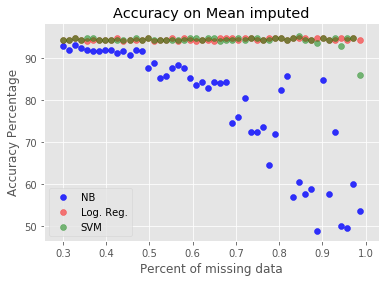

In [30]:
plt.scatter(x=missingRange, y=(acc_mean_gnb[1]*100), c="blue", label="NB", alpha=0.8)
plt.scatter(x=missingRange, y=(acc_mean_lr[1]*100), c='red', label="Log. Reg.", alpha=0.5)
plt.scatter(x=missingRange, y=(acc_mean_svm[1]*100), c='green', label="SVM", alpha=0.5)
plt.legend()
plt.xlabel("Percent of missing data")
plt.ylabel("Accuracy Percentage")
plt.title("Accuracy on Mean imputed")

Text(0.5, 1.0, 'Recall on Mean imputed')

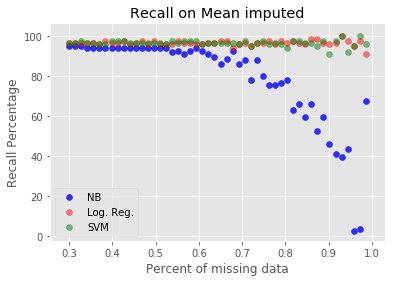

In [26]:
plt.clf()
plt.scatter(x=missingRange, y=(acc_mean_gnb[2]*100), c="blue", label="NB", alpha=0.8)
plt.scatter(x=missingRange, y=(acc_mean_lr[2]*100), c='red', label="Log. Reg.", alpha=0.5)
plt.scatter(x=missingRange, y=(acc_mean_svm[2]*100), c='green', label="SVM", alpha=0.5)
plt.legend()
plt.xlabel("Percent of missing data")
plt.ylabel("Recall Percentage")
plt.title("Recall on Mean imputed")

In [27]:
plt.clf()

<Figure size 432x288 with 0 Axes>

#### KNN Impute (K=10)

In [143]:

## 3 df's of two columns each col1: Proportion of missing data, col2: Accuracy
##  Done for KNN imputation with Gaussian NB, Log Reg, SVM
acc_knn_gnb = getMissingAccuracies(X, Y, missingRange, impute="KNN")
acc_knn_lr = getMissingAccuracies(X, Y, missingRange, impute="KNN", method = lr)
acc_knn_svm = getMissingAccuracies(X, Y, missingRange, impute="KNN", method = svm)

Text(0.5, 1.0, 'Accuracy on KNN imputed')

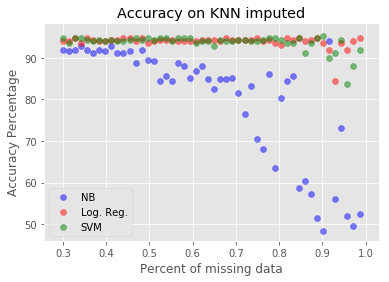

In [144]:
plt.scatter(x=missingRange, y=(acc_knn_gnb[1]*100), c="blue", label="NB", alpha=0.5)
plt.scatter(x=missingRange, y=(acc_knn_lr[1]*100), c='red', label="Log. Reg.", alpha=0.5)
plt.scatter(x=missingRange, y=(acc_knn_svm[1]*100), c='green', label="SVM", alpha=0.5)
plt.legend()
plt.xlabel("Percent of missing data")
plt.ylabel("Accuracy Percentage")
plt.title("Accuracy on KNN imputed")

Text(0.5, 1.0, 'Recall on KNN imputed')

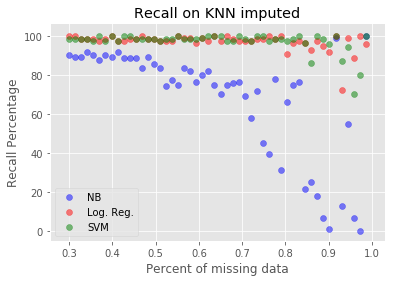

In [145]:
plt.clf()
plt.scatter(x=missingRange, y=(acc_knn_gnb[2]*100), c="blue", label="NB", alpha=0.5)
plt.scatter(x=missingRange, y=(acc_knn_lr[2]*100), c='red', label="Log. Reg.", alpha=0.5)
plt.scatter(x=missingRange, y=(acc_knn_svm[2]*100), c='green', label="SVM", alpha=0.5)
plt.legend()
plt.xlabel("Percent of missing data")
plt.ylabel("Recall Percentage")
plt.title("Recall on KNN imputed")

## Decision Boundaries 

In [146]:
def plotResults(test_X,test_Y,train_X, train_Y, title):
    #Generate grid of data points to show prediction
    x = y = np.linspace(-4,4,100)
    df = pd.DataFrame(np.array(np.meshgrid(x,y)).T.reshape(-1,2))
    df = df.rename(index=int, columns={0: "X1", 1: "X2"})

    #Plotting
    fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
    fig.set_size_inches(10, 7)
    plt.suptitle(title, y=1,fontsize=20)
    for i in range(2):
        for j in range(2):
            ax[i][j].set_ylim([-4,4])
            ax[i][j].set_xlim([-4,4])
    

    #Predict with Logistic Regression
    lr = LogisticRegression(random_state=0, solver='lbfgs').fit(train_X, train_Y)
    df["PredictionLR"] = lr.predict_proba(df.iloc[:,:2].values)[:,0]
    tn, fp, fn, tp = confusion_matrix(test_Y,lr.predict(test_X)).ravel()
    accuracy=np.around(((tp+tn)/(tn+fp+fn+tp)), 2)
    recall=np.around(((tp)/(fn+tp)), 2)

    ax[0][0].set_title("Logistic Regresion\nTest accuracy "+str(accuracy)+", recall " + str(recall))
    sns.scatterplot(x="X1",y="X2",hue="PredictionLR", data=df,ax=ax[0][0],alpha=1,s=20,marker='s',linewidth=0)
    sns.scatterplot(x=test_X[0],y=test_X[1],hue=test_Y, ax=ax[0][0])
    ax[0][0].get_legend().remove()

    #Predict with NB
    nb = GaussianNB().fit(train_X, train_Y)
    df["PredictionNB"] = nb.predict_proba(df.iloc[:,:2].values)[:,0]
    tn, fp, fn, tp = confusion_matrix(test_Y,nb.predict(test_X)).ravel()
    accuracy=np.around(((tp+tn)/(tn+fp+fn+tp)), 2)
    recall=np.around(((tp)/(fn+tp)), 2)

    ax[0][1].set_title("Naive Bayes\nTest accuracy "+str(accuracy)+", recall " + str(recall))
    sns.scatterplot(x="X1",y="X2",hue="PredictionNB", data=df,ax=ax[0][1],alpha=1,s=20,marker='s',linewidth=0)
    sns.scatterplot(x=test_X[0],y=test_X[1],hue=test_Y, ax=ax[0][1])
    ax[0][1].get_legend().remove()

    #Predict w/ QDA
    qda = QuadraticDiscriminantAnalysis().fit(train_X, train_Y)
    df["PredictionQDA"] = qda.predict_proba(df.iloc[:,:2].values)[:,0]
    tn, fp, fn, tp = confusion_matrix(test_Y,qda.predict(test_X)).ravel()
    accuracy=np.around(((tp+tn)/(tn+fp+fn+tp)), 2)
    recall=np.around(((tp)/(fn+tp)), 2)

    ax[1][0].set_title("QDA\nTest accuracy "+str(accuracy)+", recall " + str(recall))
    sns.scatterplot(x="X1",y="X2",hue="PredictionQDA", data=df,ax=ax[1][0],alpha=1,s=20,marker='s',linewidth=0)
    sns.scatterplot(x=test_X[0],y=test_X[1],hue=test_Y, ax=ax[1][0])
    ax[1][0].get_legend().remove()

    #Predict w/ Random Forest
    rf = RandomForestClassifier(n_estimators = 100).fit(train_X, train_Y)
    df["PredictionRF"] = rf.predict_proba(df.iloc[:,:2].values)[:,0]
    tn, fp, fn, tp = confusion_matrix(test_Y,rf.predict(test_X)).ravel()
    accuracy=np.around(((tp+tn)/(tn+fp+fn+tp)), 2)
    recall=np.around(((tp)/(fn+tp)), 2)

    ax[1][1].set_title("Random Forest\nTest accuracy "+str(accuracy)+", recall " + str(recall))
    sns.scatterplot(x="X1",y="X2",hue="PredictionRF", data=df, ax=ax[1][1],alpha=1,s=20,marker='s',linewidth=0)
    sns.scatterplot(x=test_X[0],y=test_X[1],hue=test_Y, ax=ax[1][1])
    ax[1][1].get_legend().remove()

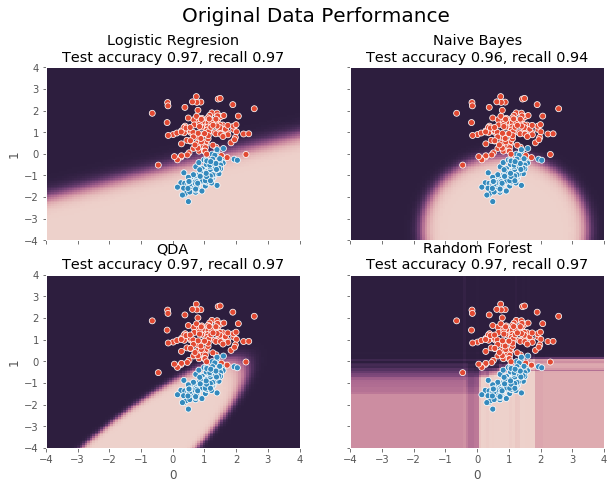

In [147]:
plotResults(X_test, Y_test[0], X, Y[0], "Original Data Performance")

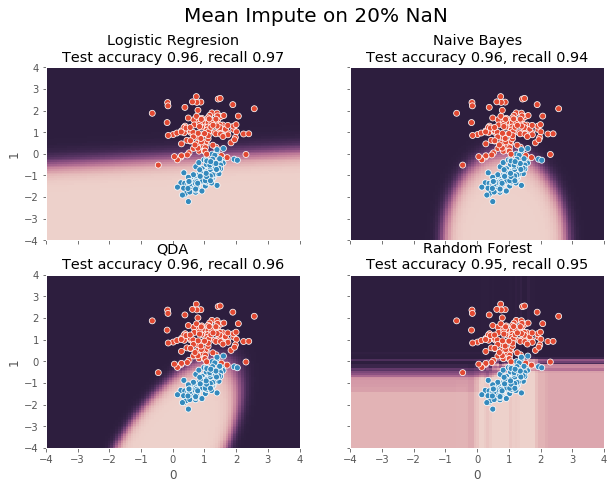

In [148]:
plotResults(X_test, Y_test[0], XmeanImpute, Y[0], "Mean Impute on 20% NaN")

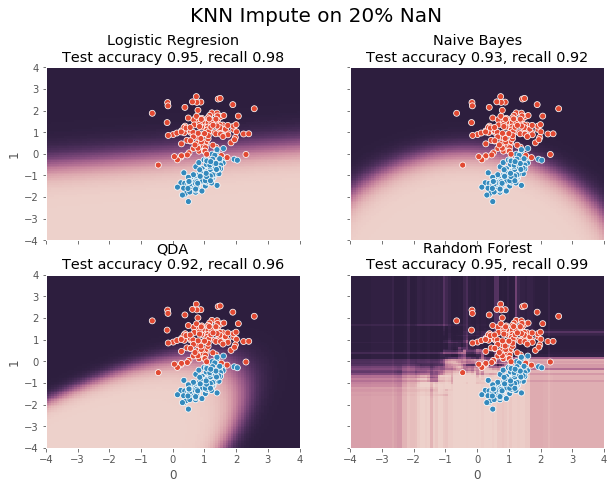

In [149]:
plotResults(X_test, Y_test[0], XknnImpute, Y[0], "KNN Impute on 20% NaN")

### 50% NaN

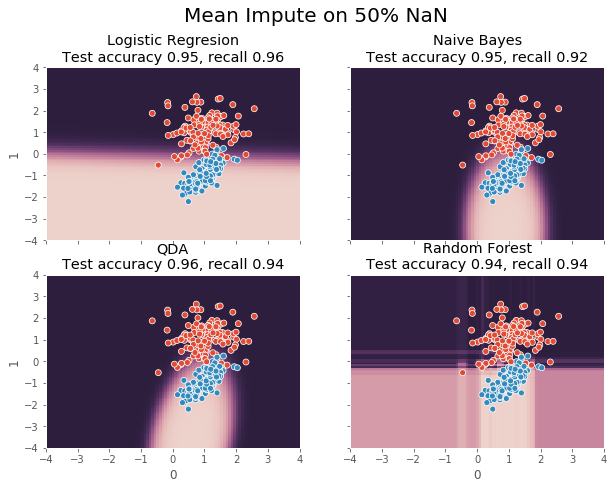

In [154]:
Xfifty = createNaNValues(X, 0.5)
XfiftyImputed = pd.DataFrame(SimpleFill().fit_transform(Xfifty))
plotResults(X_test, Y_test[0], XfiftyImputed, Y[0], "Mean Impute on 50% NaN")

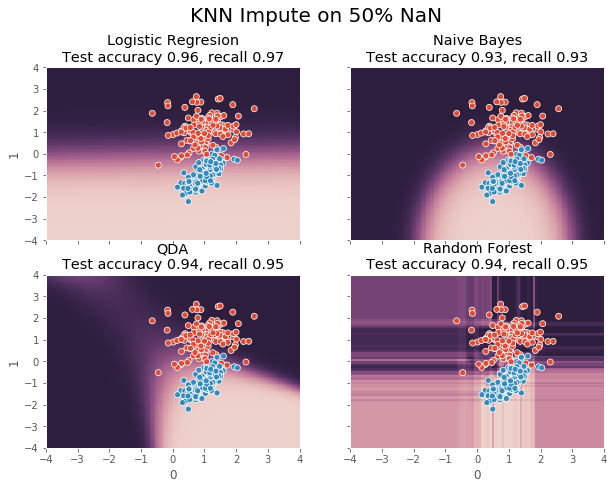

In [155]:
XfiftyKNN = KNN(k=20, verbose=False).fit_transform(Xfifty)
plotResults(X_test, Y_test[0], XfiftyKNN, Y[0], "KNN Impute on 50% NaN")

## Conclusions

**Variance Change After Imputation**
- Mean Impute will cause NB to form a tighter Decision Boundary around one class
    - more likely to misclassify new data
- KNN impute effects the variance much less
    - broader more generalizable decision boundary

**Compared with Other Techniques**
- Gaussian Naive Bayes does not do as well as other techniques in handling missing values
    - Logistic Regression, QDA, Random Forest all do better
    - Especially SVM as it only relies on support vectors
- Normalized data and NB does especially poorly after imputation
    - KNN imputation helps the data less than mean imputation 
        - then you have tighter Decision Boundary

**Overall**
- Naive Bayes performs worse on data sets with high amounts of missing data
    - This could be because 
- Look to other techniques which could lend themselves to better, and more generalizable models
